# 4章 顧客の全体像を把握する１０本ノック

引き続き、スポーツジムの会員データを使って顧客の行動を分析していきます。  
３章で顧客の全体像を把握しました。  
ここからは、機械学習を用いて顧客のグループ化や顧客の利用予測行なっていきましょう。  
ここでは、教師なし学習、教師あり学習の回帰を取り扱います。

### ノック31：データを読み込んで確認しよう

In [67]:
import pandas as pd
uselog = pd.read_csv("use_log.csv")
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [68]:
customer = pd.read_csv("customer_join.csv")
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

### ノック32：クラスタリングで顧客をグループ化しよう

In [69]:
customer_clustering = customer[["mean", "median", "max", "min", "membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [70]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

kmeans = KMeans(n_clusters = 4, random_state = 0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering["cluster"] = clusters.labels_
print(customer_clustering["cluster"].unique())
customer_clustering.head()


/Users/midorikawa/Desktop/work/udemy_code/data_analysis_100knocks/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/z_/ctypl9sd52x6ksrj93vz87xr0000gn/T/ipykernel_3092/2778052874.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_clustering["cluster"] = clusters.labels_


[1 2 3 0]


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1
2,4.583333,5.0,6,3,47,1
3,4.833333,4.5,7,2,47,1
4,3.916667,4.0,6,1,47,1


### ノック33：クラスタリング結果を分析しよう

In [71]:
customer_clustering.columns = ["月内平均値", "月内中央値", "月内最大値", "月内最小値", "会員期間", "cluster"]
customer_clustering.groupby("cluster").count()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,840,840,840,840,840
1,1249,1249,1249,1249,1249
2,771,771,771,771,771
3,1332,1332,1332,1332,1332


In [72]:
customer_clustering.groupby("cluster").mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,8.061942,8.047024,10.014286,6.175000,7.019048
1,4.677561,4.670937,7.233787,2.153723,36.915933
2,3.065504,2.900130,4.783398,1.649805,9.276265
3,5.539535,5.391141,8.756006,2.702703,14.867868


### ノック34：クラスタリング結果を可視化してみよう

In [73]:
from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]
pca_df

,0,1,cluster
0,-0.819982,-1.959097,1
1,-0.707922,-1.799857,1
2,-1.061499,-1.659826,1
3,-1.160764,-1.810139,1
4,-2.017132,-1.670101,1
...,...,...,...
4187,3.027933,1.139635,0
4188,5.064720,0.769684,0
4189,3.027933,1.139635,0
4190,6.083114,0.584708,0


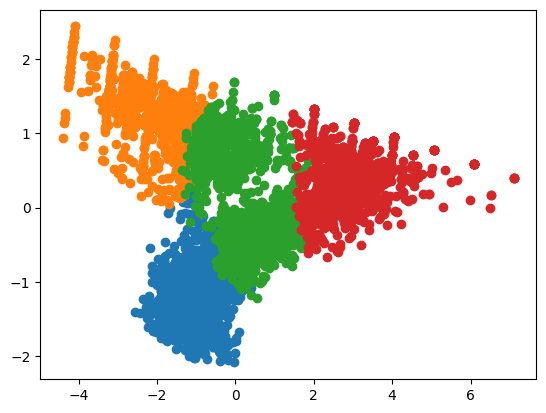

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in customer_clustering["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"]==i]
    plt.scatter(tmp[0], tmp[1])


### ノック35：クラスタリング結果をもとに退会顧客の傾向を把握しよう

In [75]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(["cluster", "is_deleted"], as_index = False).count()[["cluster", "is_deleted", "customer_id"]]

,cluster,is_deleted,customer_id
0,0,0,821
1,0,1,19
2,1,0,1231
3,1,1,18
4,2,1,771
5,3,0,790
6,3,1,542


In [76]:
customer_clustering.groupby(["cluster", "routine_flg"], as_index = False).count()[["cluster", "routine_flg", "customer_id"]]

,cluster,routine_flg,customer_id
0,0,0,52
1,0,1,788
2,1,0,2
3,1,1,1247
4,2,0,499
5,2,1,272
6,3,0,226
7,3,1,1106


### ノック36：翌月の利用回数予測を行うためのデータ準備をしよう

In [77]:
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["年月"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["年月", "customer_id"], as_index = False).count()
uselog_months.rename(columns={"log_id":"count"}, inplace = True)
del uselog_months["usedate"]
uselog_months.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [78]:
year_months = list(uselog_months["年月"].unique())
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months["年月"]==year_months[i]]
    tmp.rename(columns={"count":"count_pred"}, inplace = True)
    for j in range(1, 7):
        tmp_before = uselog_months.loc[uselog_months["年月"]==year_months[i-j]]
        del tmp_before["年月"]
        tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.head()

/var/folders/z_/ctypl9sd52x6ksrj93vz87xr0000gn/T/ipykernel_3092/4254067703.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.rename(columns={"count":"count_pred"}, inplace = True)
/var/folders/z_/ctypl9sd52x6ksrj93vz87xr0000gn/T/ipykernel_3092/4254067703.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
/var/folders/z_/ctypl9sd52x6ksrj93vz87xr0000gn/T/ipykernel_3092/4254067703.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [79]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop = True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


### ノック37：特徴となる変数を付与しよう

In [80]:
predict_data = pd.merge(predict_data, customer[["customer_id", "start_date"]], on = "customer_id", how = "left")
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [81]:
predict_data["now_date"] = pd.to_datetime(predict_data["年月"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
from dateutil.relativedelta import relativedelta
predict_data["period"] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = delta.years*12 + delta.months

predict_data.head()

/var/folders/z_/ctypl9sd52x6ksrj93vz87xr0000gn/T/ipykernel_3092/320468189.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months


,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


### ノック38：来月の利用回数予測モデルを作成しよう

In [82]:
predict_data = predict_data.loc[predict_data["start_date"]>=pd.to_datetime("20180401")]
from sklearn import linear_model
import sklearn.model_selection
model = linear_model.LinearRegression()
X = predict_data[["count_0", "count_1", "count_2", "count_3","count_4","count_5", "period"]]
y = predict_data["count_pred"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)
model.fit(X_train, y_train)

LinearRegression()

In [83]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.609713335297991
0.6033873375254912


### ノック39：モデルに寄与している変数を確認しよう

In [84]:
coef = pd.DataFrame({"feature_names": X.columns, "coefficient":model.coef_})
coef

,feature_names,coefficient
0,count_0,0.344639
1,count_1,0.179655
2,count_2,0.169396
3,count_3,0.194310
4,count_4,0.072149
5,count_5,0.066398
6,period,0.072004


### ノック40：来月の利用回数を予測しよう

In [85]:
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = [x1, x2]

In [86]:
model.predict(x_pred)

/Users/midorikawa/Desktop/work/udemy_code/data_analysis_100knocks/.venv/lib/python3.11/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([3.79648367, 1.98521372])

In [87]:
uselog_months.to_csv("use_log_months.csv", index = False)